In [1]:
%matplotlib inline
import os
import os.path
import numpy
import pandas
from matplotlib import pylab
import matplotlib
# local modules (in same dir as this notebook)
import plotutils

In [68]:
reload(plotutils)
def joint_entropy(X, Y, bins=10):
    "Computes the joint entropy of two variables using a histogram."
    H, _2, _3 = numpy.histogram2d(X, Y, bins=bins)
    H /= H.sum()
    return -numpy.nan_to_num(H * numpy.log2(H)).sum()

class TickFormat:
    "Some methods for formatting the plot ticks"
    @staticmethod
    def am_pm(x):
        "24 hour to am/pm format"
        x=int(x)
        return "{}{}".format(x%12 or 12, "pm" if (x%24) > 11 else "am")

    @staticmethod
    def kHz(x, prec=1):
        "Units in kHz, with the given precision"
        return "{}kHz".format(int(x/(1000*prec))*prec)

    @staticmethod
    def kHz_1(x):
        "Units in kHz, with one decimal precision"
        return TickFormat.kHz(x, .1)

    # Seconds
    sec = "%2ds"

    @staticmethod
    def percent(x):
        "Percentage"
        return "{}%".format(int(float(x)*100))

def print_recs_by_tod(data, rec_column='rec', tod_column='tod'):
    "Prints number of recordings by time of day."
    print "Recs by tod:"
    rec_tods = pandas.DataFrame(data.groupby([tod_column, rec_column]).groups.keys(), columns=[tod_column, rec_column])
    recs_by_tod = rec_tods.groupby(tod_column).groups.items()
    print '  ' + ' '.join([TickFormat.am_pm(x[0]) for x in recs_by_tod])
    print '  ' + ' '.join([str(len(x[1])).center(len(TickFormat.am_pm(x[0]))) for x in recs_by_tod])

def get_datasets(data_path):
    return {x.replace('sample', '').strip('_'):os.path.join(data_path, x) for x in os.listdir(data_path)}
    
def load_dataset(dataset_name, data_path, stat_names = None):
    "Loads a dataset from a given data path."
    print "Dataset:", dataset_name
    
    datasets = get_datasets(data_path)
    
    if dataset_name not in datasets:
        raise StandardError("Dataset {} not found."%dataset_name)

    data = pandas.read_csv(os.path.join(datasets[dataset_name], 'rois.txt'))
    
    # compute tod from recording filename
    data['tod'] = data['rec'].apply(
        lambda x: int(x.split('.')[0].split('_')[-1].split('-')[0]) if 'undefined' not in x else 0
    )

    print "recs: {}, rois: {}, rois per rec: {:6.2f}".format(
        len(data.groupby('rec')), 
        len(data), 
        len(data) * 1.0 / len(data.groupby('rec'))
    )

    print_recs_by_tod(data)
    
    return data[list(stat_names)] if stat_names else data

    
def print_data_stats(data, bins):
    stat_names = data.columns
    print "Stats:", ', '.join(stat_names)

    data_matrix = data.as_matrix()
    
    print "Joint Entropy:"
    print '  ' + '\n  '.join('\t'.join("{:5} X {:4}: {:5.2f}".format(
        stat_names[i], stat_names[j],
        joint_entropy(data_matrix[:, i], data_matrix[:, j], (bins[i], bins[j]))
    ) for j in range(i)) for i in range(1,len(stat_names)))


def draw_dataset_plots(data, **kwargs):
    "Draws a dataset matrix plot"
    defaults = {
        'log': True,
        'hist_log' : True,
        'mtype' : "D",
        'tick_count' : 3,
        'titlefn' : lambda ni, Xi, binsi, nj, Xj, binsj: "H: {:5.2f}".format(joint_entropy(Xi, Xj, (binsi, binsj))),
        'tick_fmt' : [
            TickFormat.am_pm,
            TickFormat.kHz,
            TickFormat.sec,
            TickFormat.kHz,
            TickFormat.percent
        ],
        'interpolation' : "nearest",
        'plotter' : plotutils.density_plot,
#         'colorbar' : True, 
#         'vmax' : 8, 
        'colorbar_text' : "log(acoustic event count)"
    }
    for defarg, defval in defaults.items():
        if defarg not in kwargs:
            kwargs[defarg] = defval
    stat_names = tuple(data.columns)
    data_matrix = data.as_matrix()
    matplotlib.rcParams['font.size'] = 18
    pylab.figure(figsize=(20,20))
    plotutils.scatterplot_matrix(
        data_matrix, 
        stat_names, **kwargs
    )

def draw_one_dataset_plot(data, var1, var2, colorbar, tick_count=3, tick_fmt=None, **kwargs):
    "Draws a dataset matrix plot"
    defaults = {
        'log': True,
        'interpolation' : "nearest",
    }
    for defarg, defval in defaults.items():
        if defarg not in kwargs:
            kwargs[defarg] = defval
    data_matrix = data[[var1, var2]].as_matrix()
    matplotlib.rcParams['font.size'] = 18
    
    if 'bins' in kwargs:
        kwargs['bins'] = (
            kwargs['bins'][list(data.columns).index(var1)],
            kwargs['bins'][list(data.columns).index(var2)]
        )
    
    pylab.figure(figsize=(20,20))
    plotutils.density_plot(
        data_matrix[:,0], data_matrix[:,1],
        **kwargs
    )
    if tick_fmt:
        plotutils.set_tick_labels(matplotlib.pyplot.gca(), 'x', tick_fmt[0], tick_count)
        plotutils.set_tick_labels(matplotlib.pyplot.gca(), 'y', tick_fmt[1], tick_count)

In [21]:
base_path = os.path.realpath(os.path.join(os.path.curdir, '..'))
data_path = os.path.join(base_path, 'samples')

stat_names = ('tod', 'bw', 'dur', 'y_max', 'Cov')
# H_bins = [24, 100, 100, 100, 100]
H_bins = [24] + [45]*4

print "Datasets:\n" + '\n'.join(get_datasets(data_path).keys())

Datasets:
sabana_seca
el_verde
validation_data
amarakaeri


Dataset: amarakaeri
recs: 236, rois: 94167, rois per rec: 399.01
Recs by tod:
  12am 1am 2am 3am 4am 5am 6am 7am 8am 9am 10am 11am 12pm 1pm 2pm 3pm 4pm 5pm 6pm 7pm 8pm 9pm 10pm 11pm
   10   10  10  9   10  10  10  10  10  8   10   10   10   10  10  10  10  10  10  10  10  10  10   9  


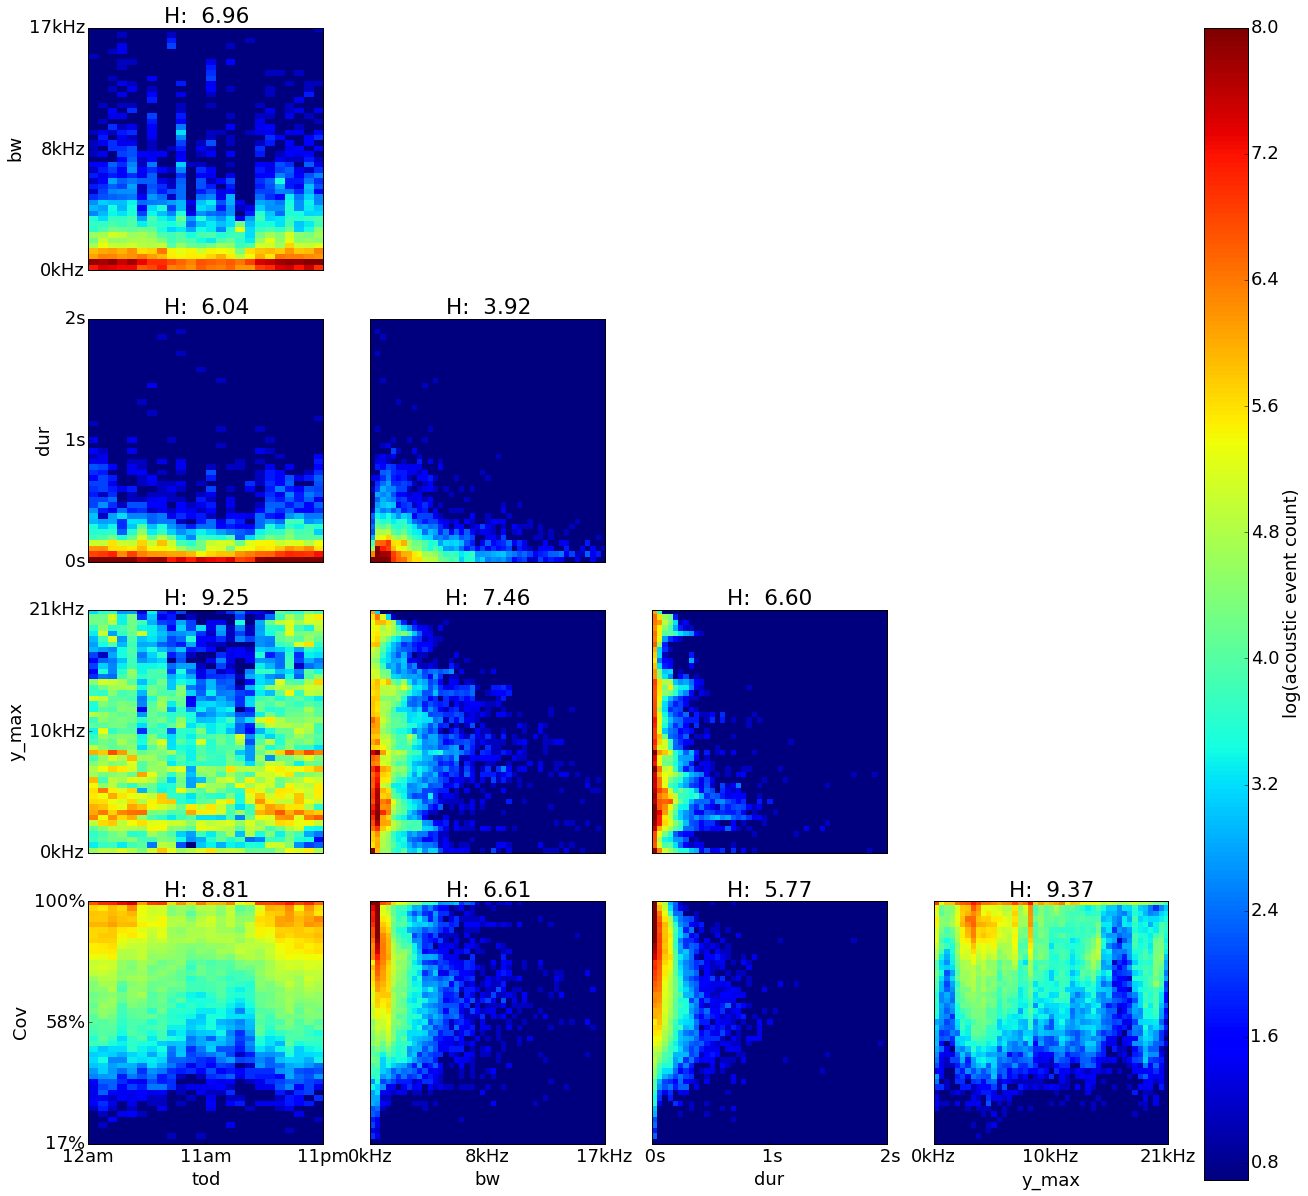

In [27]:
amarakaeri_data = load_dataset("amarakaeri", data_path, stat_names)
draw_dataset_plots(amarakaeri_data, bins=H_bins, colorbar=True, vmax=8, mtype="D")

Dataset: el_verde
recs: 238, rois: 60112, rois per rec: 252.57
Recs by tod:
  12am 1am 2am 3am 4am 5am 6am 7am 8am 9am 10am 11am 12pm 1pm 2pm 3pm 4pm 5pm 6pm 7pm 8pm 9pm 10pm 11pm
   10   10  10  10  10  10  10  10  9   10  10   10   10   10  10  10  10  10  10  10  10  10  10   9  
Stats: tod, bw, dur, y_max, Cov
Joint Entropy:
  bw    X tod :  7.00
  dur   X tod :  6.33	dur   X bw  :  4.13
  y_max X tod :  8.84	y_max X bw  :  6.98	y_max X dur :  6.31
  Cov   X tod :  9.03	Cov   X bw  :  6.76	Cov   X dur :  6.19	Cov   X y_max:  9.06


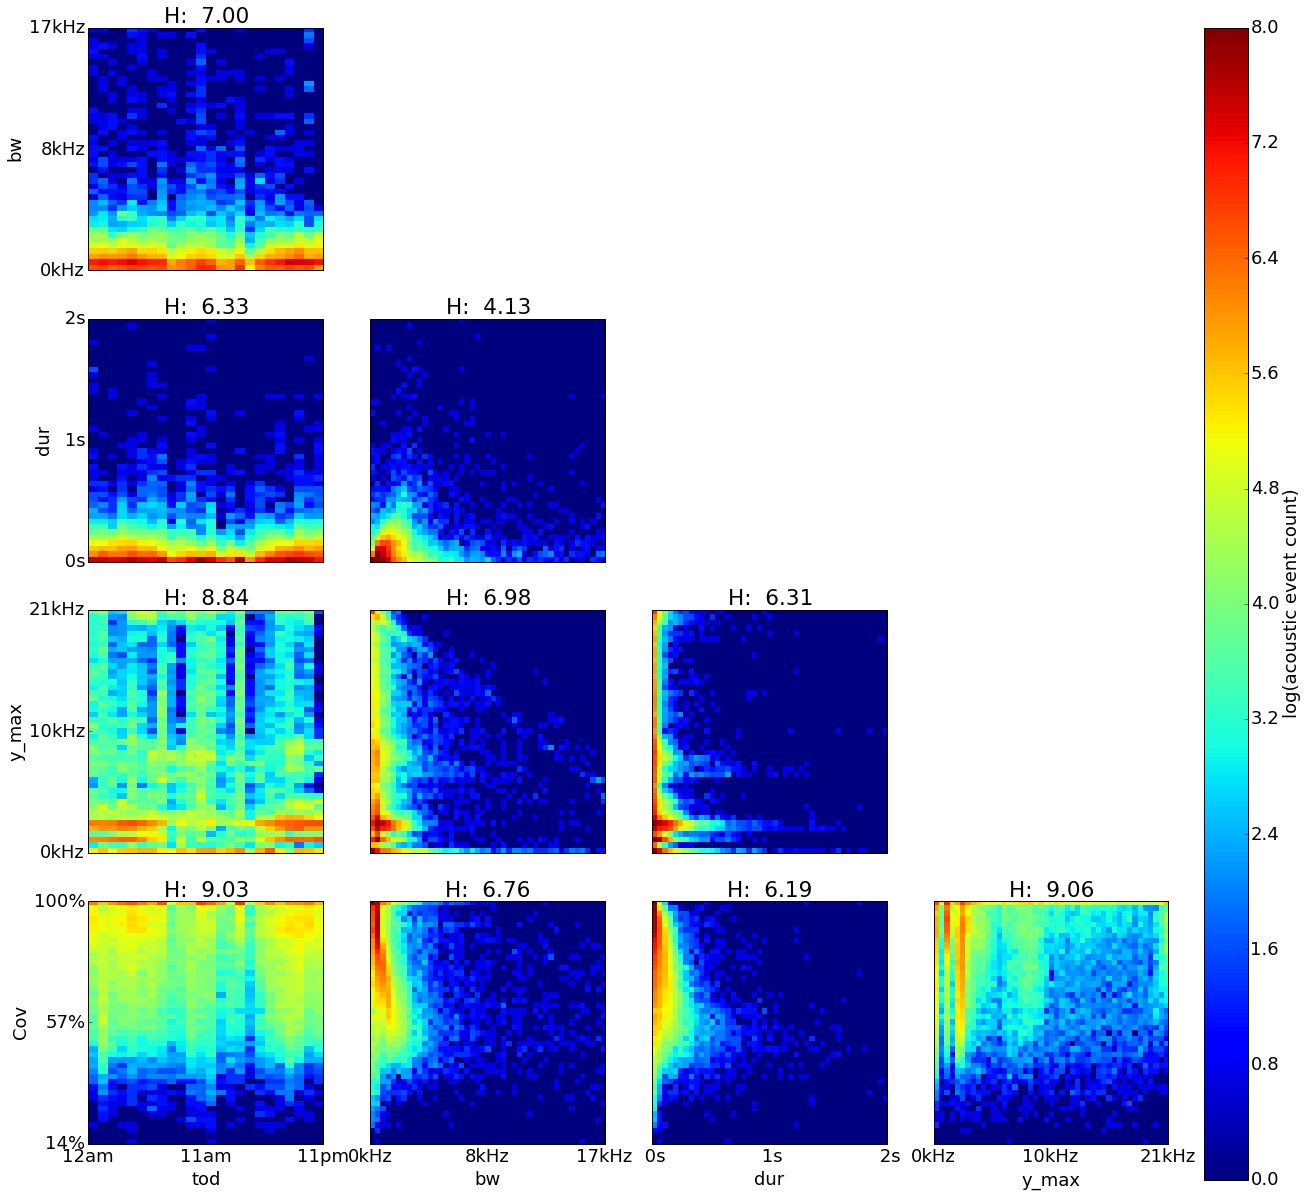

In [23]:
el_verde_data = load_dataset("el_verde", data_path, stat_names)
print_data_stats(el_verde_data, bins=H_bins)
draw_dataset_plots(el_verde_data, bins=H_bins, colorbar=True, vmax=8, mtype="D")

Dataset: sabana_seca
recs: 240, rois: 59058, rois per rec: 246.07
Recs by tod:
  12am 1am 2am 3am 4am 5am 6am 7am 8am 9am 10am 11am 12pm 1pm 2pm 3pm 4pm 5pm 6pm 7pm 8pm 9pm 10pm 11pm
   9    10  10  10  10  10  10  10  10  10  10   10   10   10  10  10  10  10  10  11  10  10  10   10 
Stats: tod, bw, dur, y_max, Cov
Joint Entropy:
  bw    X tod :  6.98
  dur   X tod :  5.95	dur   X bw  :  4.10
  y_max X tod :  8.36	y_max X bw  :  6.82	y_max X dur :  5.86
  Cov   X tod :  8.78	Cov   X bw  :  6.68	Cov   X dur :  5.78	Cov   X y_max:  8.71


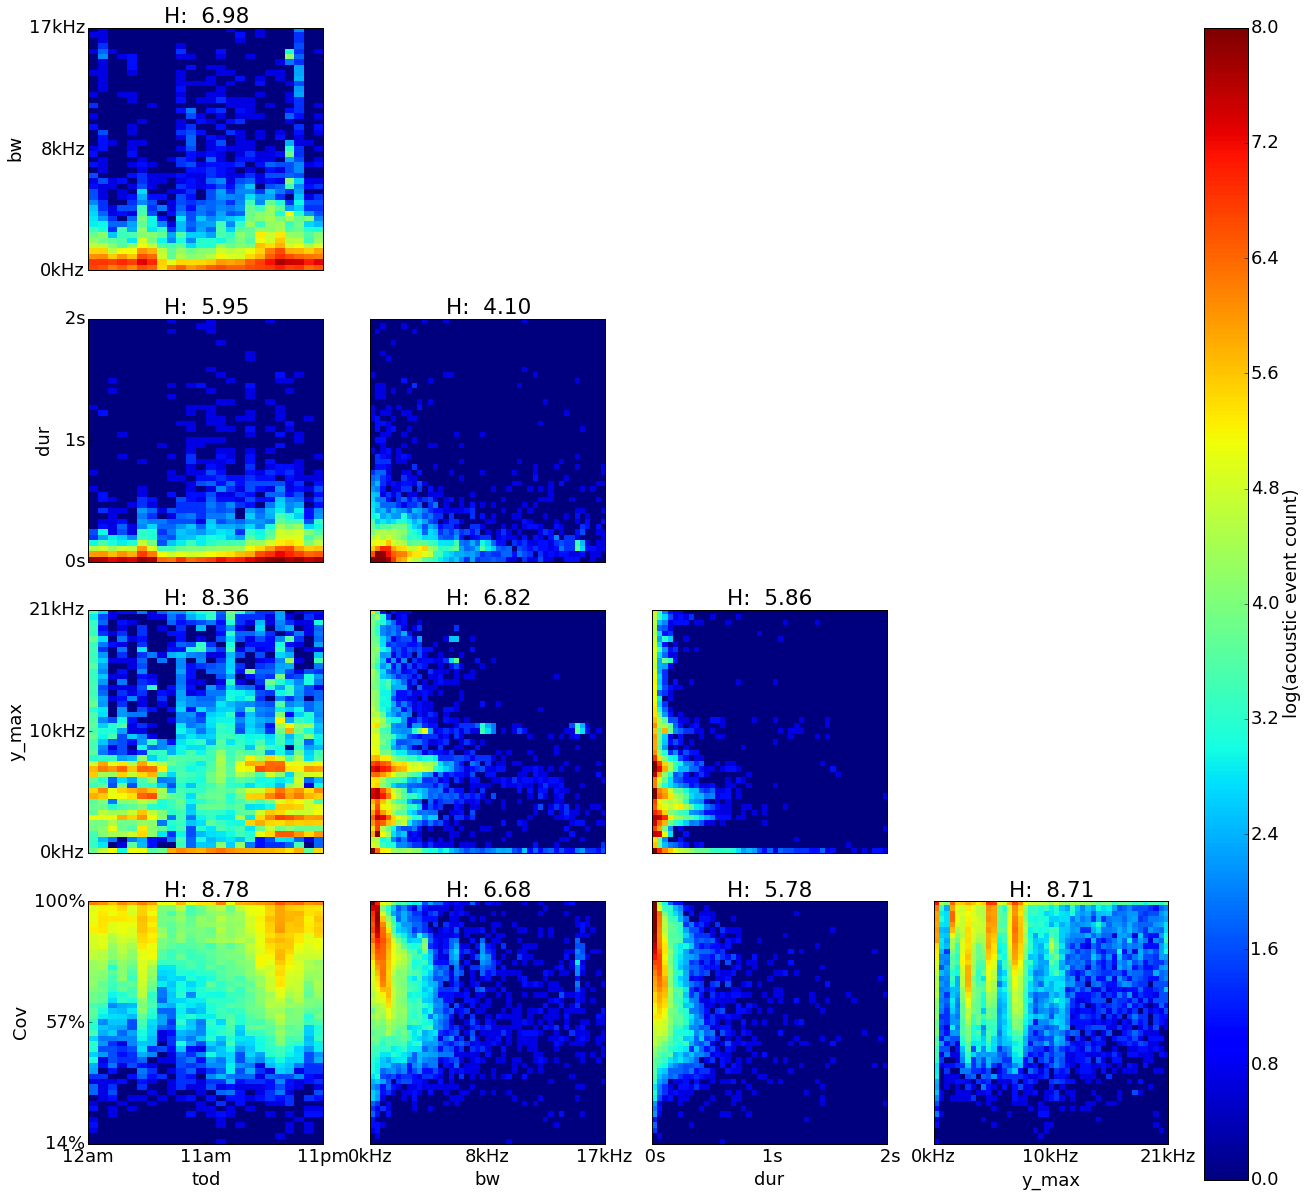

In [24]:
sabana_seca_data = load_dataset("sabana_seca", data_path, stat_names)
print_data_stats(sabana_seca_data, bins=H_bins)
draw_dataset_plots(sabana_seca_data, bins=H_bins, colorbar=True, vmax=8, mtype="D")

AOI             1
bw_min        700
bw_max       1900
y_max_min    2650
y_max_max    3550
Name: 0, dtype: int64


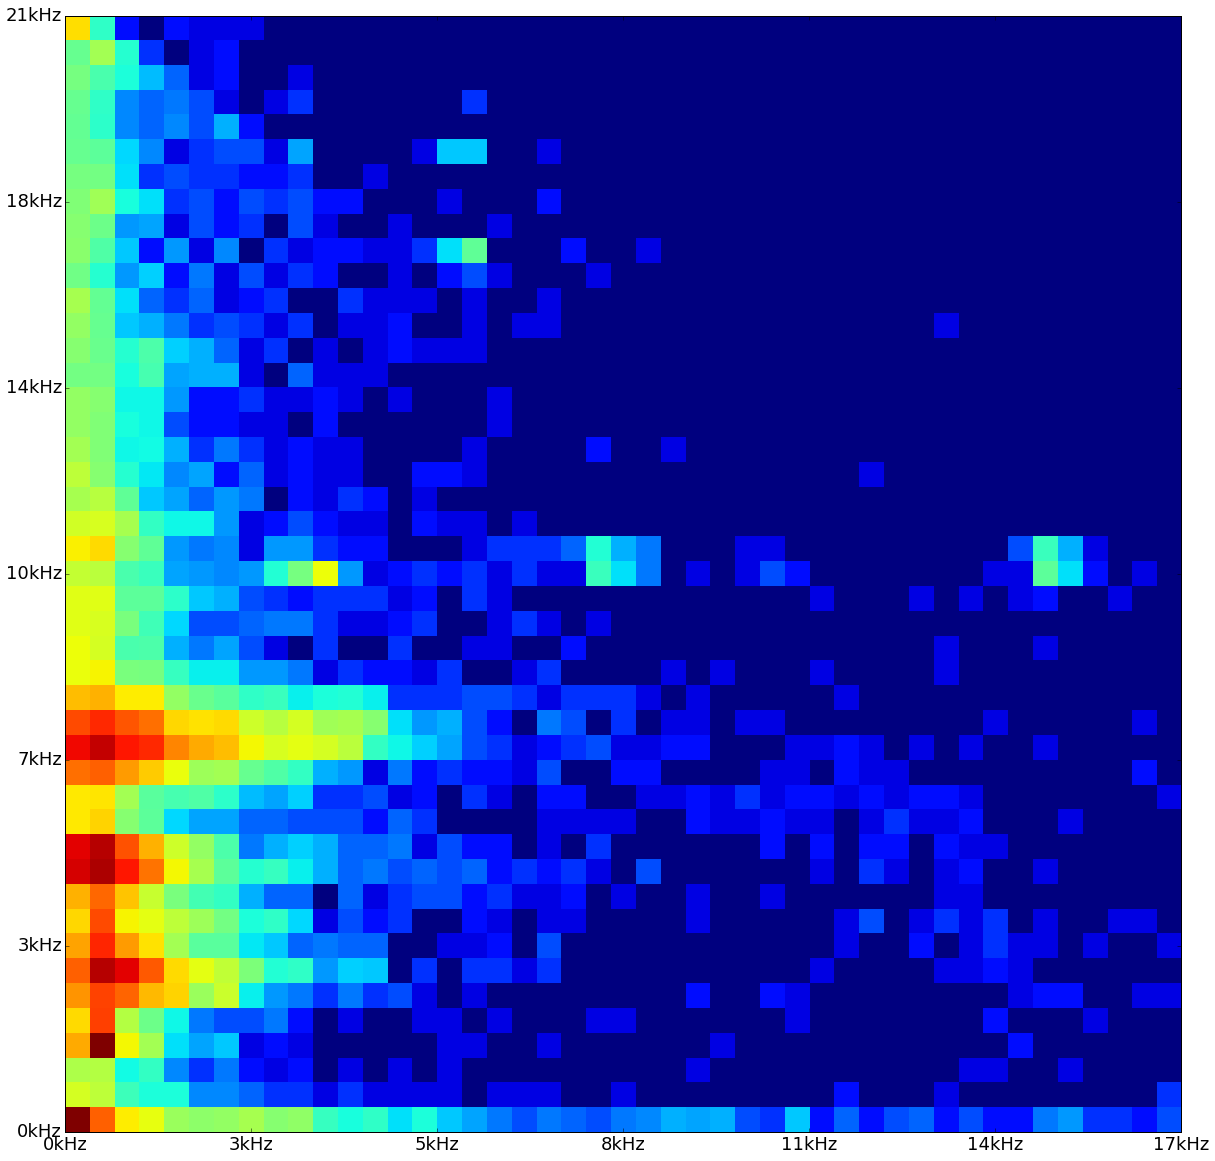

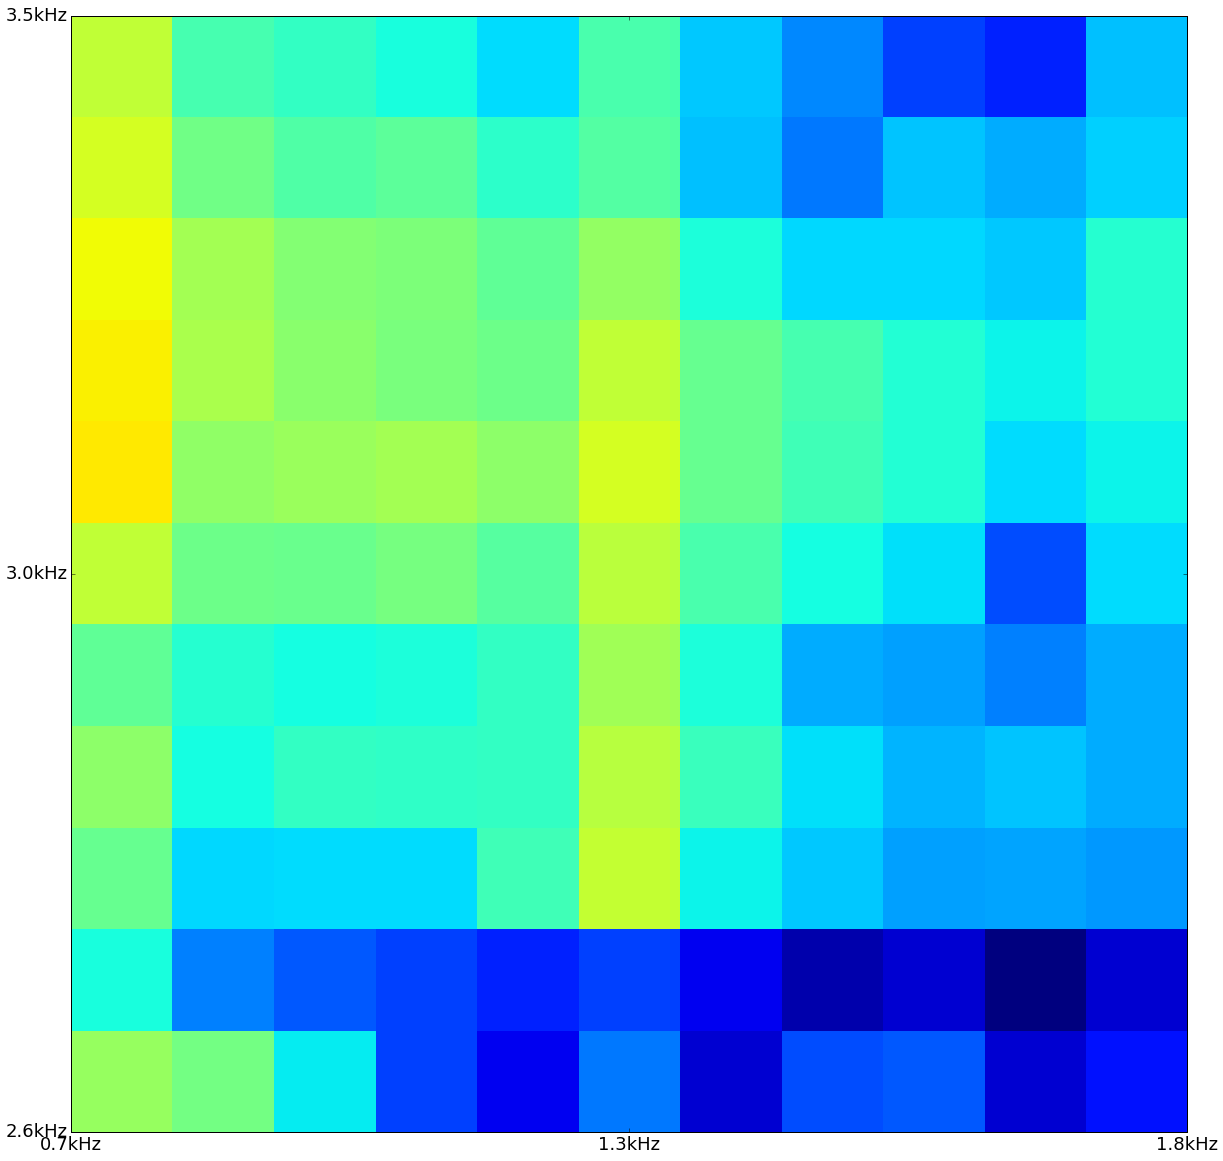

In [70]:
sabana_seca_aoi1_range = pandas.read_csv(os.path.join(get_datasets(data_path)['sabana_seca'], 'areas_of_interest.txt')).iloc[0]
sabana_seca_aoi1 = sabana_seca_data[
    (sabana_seca_data.bw >= sabana_seca_aoi_range.bw_min) &
    (sabana_seca_data.bw <= sabana_seca_aoi_range.bw_max) &
    (sabana_seca_data.y_max >= sabana_seca_aoi_range.y_max_min) &
    (sabana_seca_data.y_max <= sabana_seca_aoi_range.y_max_max)
]
# draw_one_plot(sabana_seca_aoi1, 'bw', 'y_max')
print sabana_seca_aoi_range

draw_one_dataset_plot(sabana_seca_data, 'bw', 'y_max', bins=H_bins, colorbar=True, vmax=8, 
    tick_fmt=[TickFormat.kHz,TickFormat.kHz], tick_count = 7
)


draw_one_dataset_plot(sabana_seca_aoi1, 'bw', 'y_max', bins=[x/4 for x in H_bins], colorbar=True, vmax=8, 
    tick_fmt=[TickFormat.kHz_1,TickFormat.kHz_1]
)